### Import

#### Local

In [0]:
from pathlib import PosixPath

root = PosixPath('/mnt/188f6bc0-7ce9-4833-a30f-60f6ee8c4aef/Project')

#### Colab

In [0]:
from google.colab import drive
from pathlib import PosixPath


drive.mount('/content/drive')
root = PosixPath('/content/drive/My Drive/DS/')


In [0]:
import sys

sys.path.append(str(root/'lib'))

In [0]:
from xml.dom import minidom
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.upsampling import Upsample
import cv2
from PIL import Image
from tqdm.autonotebook import tqdm
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset, DataLoader
from os.path import isfile
from joblib import dump, load
from functools import partial
from fastai.train import clip_grad
from torchvision import transforms
from ssd import SSD
from fastai.vision import *
import imagesize

/home/hvlpr/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### VOC read

In [0]:
path = root/'yolo'
voc_path = path/'voc/VOCdevkit/VOC2012/'
images_path = voc_path/'JPEGImages'
anno_path = voc_path/'Annotations'

In [0]:
images_data = {}

In [0]:
for anno in anno_path.iterdir():
    
    boxes = []
    classes = []
    with minidom.parse(str(anno)) as xmldoc:
        filename = xmldoc.getElementsByTagName('filename')[0].childNodes[0].data
        bndboxes = xmldoc.getElementsByTagName('bndbox')
        names = xmldoc.getElementsByTagName('name')
        for i in range(len(bndboxes)):
            bndbox = bndboxes[i]
            xmin = bndbox.getElementsByTagName('xmin')[0].childNodes[0].data
            xmax = bndbox.getElementsByTagName('xmax')[0].childNodes[0].data
            ymin = bndbox.getElementsByTagName('ymin')[0].childNodes[0].data
            ymax = bndbox.getElementsByTagName('ymax')[0].childNodes[0].data
            box = [ymin, xmin, ymax, xmax]
            boxes.append(box)
            name = names[i].childNodes[0].data
            classes.append(name)
        images_data[filename] = [boxes, classes]
    
    

In [0]:
dict_data = images_data

In [0]:
classes = list(set([i for x in images_data.values() for i in x[1]]))

In [0]:
classes_dict = {x: index for index, x in enumerate(classes)}
classes_dict['background'] = len(classes_dict)

In [0]:
index_dict = {val: key for key, val in classes_dict.items()}

In [0]:
# index_dict[len(index_dict)] = 'background'

In [0]:
for key in dict_data:
    val = dict_data[key]
#     val[1] = [index_dict.get(x, classes_dict.get(x, index_dict.get(x))) for x in val[1]]
    val[0] = [[float(v) for v in box] for box in val[0]]

In [0]:
# classes_dict['background'] = len(classes_dict)

In [0]:
# dump(dict_data, voc_path/'dump.pkl')

# dump(classes_dict, voc_path/'classes.pkl')

dict_data = load(voc_path/'dump.pkl')
classes_dict = load(voc_path/'classes.pkl')


#### COCO read

In [0]:
with open(anno_path) as f:
    data = json.load(f)

In [0]:
class Item:
    def __init__(self):
        self.bbox = []
        self.category = []
        self.filename = None

In [0]:
images_data = {}

In [0]:
for i in range(len(data['images'])):
    image_id = data['images'][i]['id']
    filename = data['images'][i]['file_name']
    item = Item()
    item.filename = filename
    images_data[image_id] = item

In [0]:
for i in range(len(data['annotations'])):
    image_id = data['annotations'][i]['image_id']
    bbox = data['annotations'][i]['bbox']
    bbox = [bbox[1], bbox[0], bbox[1] + bbox[3], bbox[0] + bbox[2]]
    cat = data['annotations'][i]['category_id']
    item = images_data.get(image_id, None)
    if not item is None:
        item.bbox.append(bbox)
        item.category.append(cat)

In [0]:
classes = set([x for d in list(images_data.values()) for x in d.category])

In [0]:
dict_data = {}
for val in list(images_data.values()):
    filename = val.filename
    bbox = val.bbox
    category = val.category
    if len(bbox) == 0:
        bbox = [[0, 0, 0, 0]]
        category = [1]
    dict_data[filename] = bbox, category

### Parameters

In [0]:
NBOXES = 3
N_CLASSES = len(classes_dict)
FEATURES = NBOXES*(5 + N_CLASSES)

TX = 0
TY = 1
TW = 2
TH = 3
CONF = 4
bs = 4


IMAGE_GRID = 26
IMAGE_SIZE = 300# 416 ## 
# label = [bouding box, (5), 26, 26]
BOX_SIZDE = IMAGE_SIZE / IMAGE_GRID
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOSS_REDUCTION = 'sum'

### Data

#### Data

In [0]:
def roundboxes(boxes):
    return [[[b[1], b[0], b[1] + b[3], b[0] + b[2]] for b in boxes], ['face']*len(boxes)]

def emptyboxes():
    return [[[0, 0, 0, 0]], ['background']]

In [0]:
def label_func(x):
    x = PosixPath(x).name
    return dict_data.get(x, emptyboxes())

In [0]:
train_df = pd.DataFrame({'name': list(dict_data.keys())})

In [0]:
data = ObjectItemList.from_df(train_df, path=images_path).split_by_rand_pct()
pad_collate = partial(bb_pad_collate, pad_idx='background')

In [0]:
data = data.label_from_func(label_func)\
.transform(get_transforms(), size=IMAGE_SIZE, tfm_y=True)\
.databunch(bs=bs, val_bs=bs*2, collate_fn=bb_pad_collate)


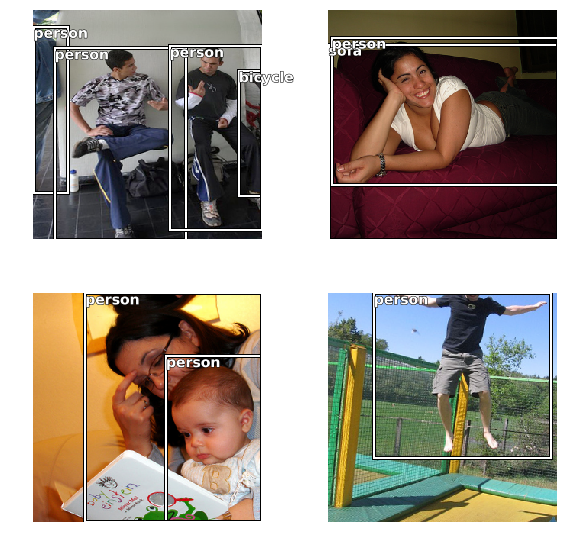

In [0]:
data.show_batch(11)

In [0]:
# data.save(voc_path/'data.bin')

### Test

In [0]:
batch = next(iter(data.train_dl))

In [0]:
batch[1][1].shape

In [0]:
batch_sample = 2
image = batch[0][batch_sample]
boxes = batch[1][0][batch_sample]

In [0]:
boxes

In [0]:
boxes = np.array([[-0.6910, -1.0000,  0.8046,  0.8126], [-0.0524, -0.5271,  0.4435, -0.3555], [-0.7457, -1.0000,  0.3988, -0.3220]])
boxes = (boxes + 1)*(IMAGE_SIZE/2)
boxes = [[x, y, w - x, h - y] for [y, x, h, w] in boxes]

In [0]:
np_image = image.permute(1, 2, 0).cpu().numpy()

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 10)

# Display the image
plt.imshow(np_image)



plt.show()

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create a Rectangle patch
for cord in boxes:
    [x, y, w, h] = [int(round(a)) for a in cord]
    print((x,y), (x+w,y+h))
    np_image = cv2.rectangle((np_image*255).astype('int32'), (x,y), (x+w,y+h), (0,255,0), 3)

# Display the image
plt.imshow(np_image)



plt.show()

### Feed

In [0]:
import gc
gc.collect()
torch.cuda.empty_cache()

net = SSD(N_CLASSES).to(device)

- Forward to calculate $(g_{c_x}, g_{c_y}, g_w, g_h)$
- Identify corresponding prior $(\hat{c}_x, \hat{c}_y, \hat{w}, \hat{h})$
- Calculate Predicted box 
    - $c_x = g_{c_x}*\hat{w} + \hat{c}_x$
    - $c_y = g_{c_y}*\hat{h} + \hat{c}_y$
    - $w = e^{g_{w}}*\hat{w}$
    - $h = e^{g_{h}}*\hat{h}$
- Calculate IoU
- Match

- Create overlapping table between predicted and ground truth (8732*number of ground truth object)
- Match each priors with greatest overlap
- Categorize as positive and negative match
- Calculate loss

### Loss

In [0]:
eps = 1e-6


def iou_table(x, truth, bs, nboxes, maxlen):
    ious = torch.zeros(bs, nboxes, maxlen) # (bs, 8732, maxlen)

    for i in range(ious.shape[-1]):
        pred_xA = x[:, 0, :] - x[:, 2, :]/2
        pred_yA = x[:, 1, :] - x[:, 3, :]/2
        pred_xB = x[:, 0, :] + x[:, 2, :]/2
        pred_yB = x[:, 1, :] + x[:, 3, :]/2
        truth_xA = truth[:, 0, i] - truth[:, 2, i] / 2
        truth_yA = truth[:, 1, i] - truth[:, 3, i] / 2
        truth_xB = truth[:, 0, i] + truth[:, 2, i] / 2
        truth_yB = truth[:, 1, i] + truth[:, 3, i] / 2
        xA = torch.max(pred_xA.contiguous().view(-1), truth_xA[:, None].expand_as(pred_xA).contiguous().view(-1)).view(bs, -1)
        yA = torch.max(pred_yA.contiguous().view(-1), truth_yA[:, None].expand_as(pred_yA).contiguous().view(-1)).view(bs, -1)
        xB = torch.min(pred_xB.contiguous().view(-1), truth_xB[:, None].expand_as(pred_xB).contiguous().view(-1)).view(bs, -1)
        yB = torch.min(pred_yB.contiguous().view(-1), truth_yB[:, None].expand_as(pred_yB).contiguous().view(-1)).view(bs, -1)
       
        
        
        interX = torch.clamp(xB - xA + 1/IMAGE_SIZE, min=0)
        interY = torch.clamp(yB - yA + 1/IMAGE_SIZE, min=0)
        interArea =  interX* interY
        
    
        boxAArea = (pred_xB - pred_xA + 1/IMAGE_SIZE) * (pred_yB - pred_yA + 1/IMAGE_SIZE)
        boxBArea = (truth_xB - truth_xB + 1/IMAGE_SIZE) * (truth_yB - truth_yA + 1/IMAGE_SIZE)
        boxBArea = boxBArea[:, None].expand_as(boxAArea)
        ious[:, :, i] = interArea / torch.clamp(boxAArea + boxBArea - interArea, min=eps) # [bs, 8732, maxlen]
    return ious



def ssd_loss(out, truth_loc, truth_conf, smoothl1, cre, iou_thres=0.6):
    loc, conf = out
    assert len(loc) == 6
    assert len(conf) == 6
    assert len(loc[0].shape) == 4 
    bs = truth_loc.shape[0]
    maxlen = truth_loc.shape[1]
    truth = truth_loc.permute(0, 2, 1) # (bs, 4, maxlen)
    # offset (calculate center)
    truth = (truth + 1)*(IMAGE_SIZE/2)
    truth[:, 0, :], truth[:, 1 ,:] = truth[:, 1 ,:], truth[:, 0 ,:]
    truth[:, 2, :], truth[:, 3, :] = truth[:, 3, :] - truth[:, 0, :], truth[:, 2, :] - truth[:, 1 ,:]
    truth[:, 0, :], truth[:, 1 ,:] = truth[:, 0, :] + 0.5*truth[:, 2, :], truth[:, 1 ,:] + 0.5*truth[:, 3, :]
    
    
    truth = truth/IMAGE_SIZE
    
    
    for i in range(len(loc)):
        assert torch.sum(torch.isnan(loc[i])) == 0, "loc is NaN"
        loc[i] = loc[i].reshape(bs, -1, 4, loc[i].shape[-1], loc[i].shape[-1])
        conf[i] = conf[i].reshape(bs, -1, N_CLASSES, loc[i].shape[-1], loc[i].shape[-1])
        
    """
        loc:
            - (4, 4, 38, 38)
            - (6, 4, 19, 19)
            - (6, 4, 10, 10)
            - (6, 4, 5, 5)
            - (4, 4, 3, 3)
            - (4, 4, 1, 1)
            
        conf:
            - (4, n_classes, 38, 38)
            - (6, n_classes, 19, 19)
            - (6, n_classes, 10, 10)
            - (6, n_classes, 5, 5)
            - (4, n_classes, 3, 3)
            - (4, n_classes, 1, 1)
        truth_loc: (bs, maxlen, 4)
        truth_conf: (bs, maxlen)
    """
    
    
    ratios4 = [1, 2, 0.5, 1]
    ratios6 = [1, 2, 0.5, 3, 1/3, 1]
    
    ratios_map = [ ratios4, ratios6, ratios6, ratios6, ratios4, ratios4]
    scales = [0.1, 0.2, 0.375, 0.55, 0.725, 0.9]
    
    pred = []
    priors = []
    
    for index in range(len(loc)):
        prior = torch.zeros_like(loc[index]) # bs, -1, 4, loc[i].shape[-1], loc[i].shape[-1]
        # calculate prior (cx, cy)
        for row in range(prior.shape[-1]):
            for col in range(prior.shape[-1]):
                prior[..., 0, row, col] = (0.5 + row) / prior.shape[-1] # Prior cx
                prior[..., 1, row, col] = (0.5 + col) / prior.shape[-1] # prior cy
        # calculate prior (w, h)
        ratios = ratios_map[index]
        scale = scales[index]
        for i in range(len(ratios)):
            r = ratios[i]
            if i == len(ratios) - 1:
                scale = scale*1.5
            w = scale*np.sqrt(r)
            h = scale/np.sqrt(r)
            # w
            prior[..., i, 2, :, :]  = w/prior.shape[-1]
            prior[..., i, 3, :, :] = h/prior.shape[-1]
        # done prior
        # cx
        assert torch.sum(torch.isnan(prior)) == 0, "prior is NaN"
        pred_box = torch.zeros_like(loc[index])
        pred_box[...,0,:,:] = loc[index][...,0,:,:]*prior[...,2,:,:] + prior[...,0,:,:]
        pred_box[...,1,:,:] = loc[index][...,1,:,:]*prior[...,3,:,:] + prior[...,1,:,:]
        pred_box[...,2,:,:] = torch.exp(loc[index][...,2,:,:])*prior[...,2,:,:]
        pred_box[...,3,:,:] = torch.exp(loc[index][...,3,:,:])*prior[...,3,:,:]
        priors.append(prior)
        pred_box = pred_box.permute(0, 2, 1, 3, 4).contiguous().view(bs, 4, -1)
        pred_box = torch.clamp(pred_box, min=0, max=1)
        assert torch.sum(torch.isnan(pred_box)) == 0, "Pred is NaN"
        pred.append(pred_box)
    
    pred = torch.cat(pred, dim=2) # (bs, 4, 8732)
    assert list(pred.shape) == [bs, 4, 8732]
    
    assert list(truth.shape) == [bs, 4, maxlen]
    # IoU
    ious = iou_table(pred, truth=truth, bs=bs, nboxes=pred.shape[-1], maxlen=maxlen)
    pconf = torch.cat([c.permute(0, 1, 3, 4, 2).contiguous().view(bs, -1, N_CLASSES) for c in conf], dim=1)
    assert list(pconf.shape) == [bs, 8732, N_CLASSES]
    max_ious, max_match = torch.max(ious, dim=2)
    positive_match = max_ious > iou_thres # (bs, 8732)
    assert list(positive_match.shape) == [bs, 8732]
    pos_pred = pred.permute(0, 2, 1)[positive_match] # (total_match in batch, 4)
    # done
    # 443 -> 4, 4, 3, 8732
    tr = truth[..., None].expand(*truth.shape, 8732).permute(0, 3, 2, 1) # 4, 8732, 3, 4
    assert list(tr.shape) == [bs, 8732, maxlen, 4]
    
    
    
    
    
    
    truth_mask = torch.zeros_like(ious).byte().view(-1, maxlen) # (bs, 8732, maxlen)
    truth_mask.scatter_(1, max_match.view(-1)[:, None], 1.)
    truth_mask = truth_mask.view(bs, -1, maxlen)
    
    assert torch.sum(truth_mask).item() == 8732*bs, "Total number of item is {}".format(torch.sum(truth_mask).item())
    
    # pass
    truth_mask = positive_match[..., None]*truth_mask
    tr = tr[truth_mask]
    
    
    assert list(tr.shape) == list(pos_pred.shape)
    loc_loss = smoothl1(pos_pred, tr)
    # confidence loss
    """
    
    
    """
    assert list(pconf.shape) == [bs, 8732, N_CLASSES]
    
    
    
    priors = torch.cat([c.permute(0, 1, 3, 4, 2).contiguous().view(bs, -1, 4) for c in priors], dim=1)
    assert list(priors.shape) == [bs, 8732, 4]
    priors = priors.permute(0, 2, 1)
    truth_ious = iou_table(priors, truth=truth, bs=bs, nboxes=pred.shape[-1], maxlen=maxlen)

    max_iou, max_index = torch.max(truth_ious, dim=-1)# [bs, 8732], [bs, 8732]
    # index: (bs, 8732) value (bs, 8732, maxlen)
    truth_conf = truth_conf[:, None, :].expand(bs, 8732, maxlen) # (bs, 8732, maxlen)
    assert list(truth_conf.shape) == [bs, 8732, maxlen]
    tcof = truth_conf.gather(2, max_index[..., None].to(device))
    tcof[max_iou < iou_thres] = 0
    assert list(tcof.shape) == [bs, 8732, 1], "Got shape {}".format(list(tcof.shape))
    """
    Use truth_ious as a mask
    """
    
    tcof = tcof.view(bs, -1)
    
    npos = torch.clamp(torch.sum(tcof > 0), min=1e-3)
    nneg = 3*npos
    
    pos_index = tcof > 0
    neg_index = tcof == 0
    if npos > eps:
        conf_pos_loss = cre(pconf[pos_index].view(-1, N_CLASSES), tcof[pos_index].view(-1))
    else:
        conf_pos_loss = 0
    if nneg >= 1:
        
        p = pconf[neg_index].view(-1, N_CLASSES)
        t = tcof[neg_index].view(-1, 1)
        
        maxp = torch.max(p, dim=1)[0]
        
        max_error = torch.topk(maxp, int(nneg.item()), dim=0)[1]
        p = p[max_error, :]
        t = t[max_error, :]
        
        conf_neg_loss = cre(p, t.view(-1))
    else:
        conf_neg_loss = 0
    
    conf_loss = conf_pos_loss + conf_neg_loss
    
    return (loc_loss + conf_loss)

In [0]:
loss = partial(ssd_loss, smoothl1=nn.SmoothL1Loss(reduction='sum'), cre=nn.CrossEntropyLoss(reduction='sum'))

In [0]:
opt = partial(torch.optim.SGD, lr=1e-3, momentum=0.9, weight_decay=0.0005)

In [0]:
learn = Learner(data, net, loss_func=loss, opt_func=opt)
learn = clip_grad(learn, clip=1)

In [0]:
# learn.lr_find()

In [0]:
for i in range(3):
    learn.fit(1) # 9500
    learn.save(path/'_weight_{}.bin'.format(i))

epoch,train_loss,valid_loss,time


### Inference

In [0]:
test_path = PosixPath('/content/drive/My Drive/DS/yolo/WIDER_test/images')
test_data = []
for label in os.listdir(test_path):
    for file in os.listdir(test_path/label):
        test_data.append(label + '/' + file)


import random

random.shuffle(test_data)
sample_test_data = test_data[:32]
sample_test_data = [PIL.Image.open(test_path/x) for x in sample_test_data]

In [0]:
sample_test_data = [train_tfms(x) for x in sample_test_data]

In [0]:
sample_test_data = torch.cat([x[None, ...] for x in sample_test_data], dim=0)

In [0]:
sample_test_data = sample_test_data.to(device)

In [0]:
with torch.no_grad():
    out = learn.model(sample_test_data)

In [0]:
out26 = out[1]

In [0]:
boxes = label2box(out26)

In [0]:
boxes[0]

In [0]:
out26[:, :, CONF, 0, 0]